In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


data = [[0.002, 105, 15], [0.002, 105, 31], [0.0025, 105, 41.333333], [0.0025, 140, 50.75], [0.003, 70, 47.75], [0.003, 105, 95.5], [0.003, 140, 120.25], [0.0035, 70, 51.5], [0.0035, 105, 111], [0.0035, 140, 132.75], [0.004 , 35, 40], [0.004 , 70, 75.25], [0.004 , 105, 137.75], [0.004 , 140, 167], [0.0045 , 35, 25.5], [0.0045 , 70, 97.25], [0.0045 , 105, 159.25], [0.0045 , 140, 189.75], [0.005 , 35, 17.3333333333333], [0.005 , 70, 81.25], [0.005 , 105, 150.75], [0.005 , 140, 174.5], [0.0055 , 35, 26.5], [0.0055 , 70, 109], [0.0055 , 105, 180.5], [0.0055 , 140, 205.5], [0.006 , 35, 30], [0.006 , 70, 103.25], [0.006 , 105, 166.5], [0.006 , 140, 204], [0.0065 , 35, 53.5], [0.0065 , 70, 137], [0.0065 , 105, 210.75], [0.0065 , 140, 234.75], [0.007 , 35, 67.25], [0.007 , 70, 153], [0.007 , 105, 229.25], [0.007 , 140, 249.5], [0.0075 , 35, 69.5], [0.0075 , 70, 149.75], [0.0075 , 105, 215.25], [0.0075 , 140, 251.25], [0.008 , 35, 69.75], [0.008 , 70, 156.5], [0.008 , 105, 227], [0.008 , 140, 257.25], [0.0085 , 35, 81.5], [0.0085 , 70, 166.75], [0.0085 , 105, 258.75], [0.0085 , 140, 284.25], [0.009 , 35, 66.25], [0.009 , 70, 153.25], [0.009 , 105, 233.75], [0.009 , 140, 254.25], [0.0095 , 35, 55.5], [0.0095 , 70, 154.5], [0.0095 , 105, 240.5], [0.0095 , 140, 264.5],[0.01 , 35, 77.25], [0.01 , 70, 165], [0.01 , 105, 250], [0.01 , 140, 277.75]]

experiment_df = pd.DataFrame(data, columns=['intensity', 'exposure_time', 'cured_height'])

# 모델 함수 정의
# def model_function(x, a, b, c, d):
#     return np.log(b * x + c) / np.log(a) + d
def model_function(x, b, c, d):
    return np.log(b * x + c) + d

grouped = experiment_df.groupby('intensity')
intensity_data = grouped.apply(lambda x: (x['exposure_time'].to_numpy(), x['cured_height'].to_numpy()))


# 결과 출력
for intensity, values in intensity_data.items():
    x_data = values[0]
    y_data = values[1]

    if (len(x_data) < 4):
        continue
    print(x_data)
    # 초기 파라미터 추측
    initial_guess = [1, 1, 1]

    # 파라미터 최적화
    params, params_covariance = curve_fit(model_function, x_data, y_data, p0=initial_guess)

    # 최적화된 파라미터 출력
    print("Optimized parameters: b={}, c={}, d={}".format(params[0], params[1], params[2]))

    df_origin = pd.read_csv('./data_origin_scale.csv')
    unique_exposure_times = df_origin['exposure_time'].unique()
    x_data_to_pred = np.sort(unique_exposure_times)

    mask = np.isin(x_data_to_pred, x_data)
    close_mask = np.array([np.any(np.isclose(x, x_data)) for x in x_data_to_pred])
    combined_mask = mask | close_mask

    # 근접한 값이나 정확히 일치하는 값을 제외합니다.
    x_data_to_pred_filtered = x_data_to_pred[~combined_mask]

    # x_data_to_pred_filtered에서 예측을 수행합니다.
    y_pred_filtered = model_function(x_data_to_pred_filtered, *params)
    print(y_pred_filtered)
    # 시각화
    plt.figure(figsize=(10, 5))
    plt.scatter(x_data, y_data, color='blue', label='Test Data')
    plt.plot(x_data_to_pred_filtered, y_pred_filtered, color='red', label='Interpolation')
    plt.title('Cured Height vs. Exposure Time: Model Fit')
    plt.xlabel('Exposure Time (seconds)')
    plt.ylabel('Cured Height (units)')
    plt.legend()
    plt.show()


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from make_dataset import apply_scaler
from torch.utils.data import DataLoader
from scipy.optimize import curve_fit


data = [[0.002, 105, 15], [0.002, 140, 31], [0.0025, 105, 41.333333], [0.0025, 140, 50.75], [0.003, 70, 47.75], [0.003, 105, 95.5], [0.003, 140, 120.25], [0.0035, 70, 51.5], [0.0035, 105, 111], [0.0035, 140, 132.75], [0.004 , 35, 40], [0.004 , 70, 75.25], [0.004 , 105, 137.75], [0.004 , 140, 167], [0.0045 , 35, 25.5], [0.0045 , 70, 97.25], [0.0045 , 105, 159.25], [0.0045 , 140, 189.75], [0.005 , 35, 17.3333333333333], [0.005 , 70, 81.25], [0.005 , 105, 150.75], [0.005 , 140, 174.5], [0.0055 , 35, 26.5], [0.0055 , 70, 109], [0.0055 , 105, 180.5], [0.0055 , 140, 205.5], [0.006 , 35, 30], [0.006 , 70, 103.25], [0.006 , 105, 166.5], [0.006 , 140, 204], [0.0065 , 35, 53.5], [0.0065 , 70, 137], [0.0065 , 105, 210.75], [0.0065 , 140, 234.75], [0.007 , 35, 67.25], [0.007 , 70, 153], [0.007 , 105, 229.25], [0.007 , 140, 249.5], [0.0075 , 35, 69.5], [0.0075 , 70, 149.75], [0.0075 , 105, 215.25], [0.0075 , 140, 251.25], [0.008 , 35, 69.75], [0.008 , 70, 156.5], [0.008 , 105, 227], [0.008 , 140, 257.25], [0.0085 , 35, 81.5], [0.0085 , 70, 166.75], [0.0085 , 105, 258.75], [0.0085 , 140, 284.25], [0.009 , 35, 66.25], [0.009 , 70, 153.25], [0.009 , 105, 233.75], [0.009 , 140, 254.25], [0.0095 , 35, 55.5], [0.0095 , 70, 154.5], [0.0095 , 105, 240.5], [0.0095 , 140, 264.5],[0.01 , 35, 77.25], [0.01 , 70, 165], [0.01 , 105, 250], [0.01 , 140, 277.75]]

def model(x, params):
    a, b, c, d = params[0], params[1], params[2], params[3]
    # log_a(bx + c) + d, log_a(bx + c)는 log(bx + c) / log(a)
    return torch.log(b * x + c) / torch.log(a) + d

df_origin = pd.read_csv('./data_minmax_scale.csv')
unique_exposure_times = df_origin['exposure_time'].unique()
x_data_to_pred = np.sort(unique_exposure_times)

experiment_df = pd.DataFrame(data, columns=['intensity', 'exposure_time', 'cured_height'])

with open('./scalers.pkl', 'rb') as f:
    scalers = pickle.load(f)

experiment_scaled_df = apply_scaler(experiment_df, loaded_scalers=scalers)
experiment_scaled_df.to_csv('data_experiment.csv', index=False)
grouped = experiment_scaled_df.groupby('intensity')

for name, group in grouped:
    x = torch.tensor(group['exposure_time'].values, dtype=torch.float32)
    y = torch.tensor(group['cured_height'].values, dtype=torch.float32)

    x_data = group['exposure_time'].to_numpy()
    y_data = group['cured_height'].to_numpy()
    mask = np.isin(x_data_to_pred, x_data)
    close_mask = np.array([np.any(np.isclose(x, x_data)) for x in x_data_to_pred])
    combined_mask = mask | close_mask
    x_data_to_pred_filtered = x_data_to_pred[~combined_mask]
    
    params = torch.tensor([2.0, 1.0, 1.0, 0.0], requires_grad=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam([params], lr=0.001)
    min_loss =float('inf')
    attempt = 0
    while attempt < 10:
        optimizer.zero_grad()
        output = model(x, params)
        loss = criterion(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if loss.item() < min_loss:
            min_loss = loss.item()
            attempt = 0
        else:
            attempt += 1
    
    print(f"Intensity {name}: Optimized parameters: a={params[0]} b={params[1]}, c={params[2]}, d={params[3]}")
    
    x_data_to_pred_filtered_tensor = torch.tensor(x_data_to_pred_filtered)
    y_pred_filtered = model(x_data_to_pred_filtered_tensor, params).detach().numpy()
    intensity = name
    plt.figure(figsize=(10, 5))
    plt.scatter(x_data, y_data, color='blue', label='Test Data')
    plt.plot(x_data_to_pred_filtered, y_pred_filtered, color='red', label='Interpolation')
    plt.title('Cured Height vs. Exposure Time: Model Fit for Intensity {:.4f}'.format(intensity))
    plt.xlabel('Exposure Time (seconds)')
    plt.ylabel('Cured Height (units)')
    plt.legend()
    plt.show()
# input = torch.tensor(experiment_scaled_df.values, dtype=torch.float32)
# print(input)

TypeError: model() missing 3 required positional arguments: 'b', 'c', and 'd'

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from make_dataset import apply_scaler
from torch.utils.data import DataLoader
from scipy.optimize import curve_fit


data = [[0.002, 105, 15], [0.002, 140, 31], [0.0025, 105, 41.333333], [0.0025, 140, 50.75], [0.003, 70, 47.75], [0.003, 105, 95.5], [0.003, 140, 120.25], [0.0035, 70, 51.5], [0.0035, 105, 111], [0.0035, 140, 132.75], [0.004 , 35, 40], [0.004 , 70, 75.25], [0.004 , 105, 137.75], [0.004 , 140, 167], [0.0045 , 35, 25.5], [0.0045 , 70, 97.25], [0.0045 , 105, 159.25], [0.0045 , 140, 189.75], [0.005 , 35, 17.3333333333333], [0.005 , 70, 81.25], [0.005 , 105, 150.75], [0.005 , 140, 174.5], [0.0055 , 35, 26.5], [0.0055 , 70, 109], [0.0055 , 105, 180.5], [0.0055 , 140, 205.5], [0.006 , 35, 30], [0.006 , 70, 103.25], [0.006 , 105, 166.5], [0.006 , 140, 204], [0.0065 , 35, 53.5], [0.0065 , 70, 137], [0.0065 , 105, 210.75], [0.0065 , 140, 234.75], [0.007 , 35, 67.25], [0.007 , 70, 153], [0.007 , 105, 229.25], [0.007 , 140, 249.5], [0.0075 , 35, 69.5], [0.0075 , 70, 149.75], [0.0075 , 105, 215.25], [0.0075 , 140, 251.25], [0.008 , 35, 69.75], [0.008 , 70, 156.5], [0.008 , 105, 227], [0.008 , 140, 257.25], [0.0085 , 35, 81.5], [0.0085 , 70, 166.75], [0.0085 , 105, 258.75], [0.0085 , 140, 284.25], [0.009 , 35, 66.25], [0.009 , 70, 153.25], [0.009 , 105, 233.75], [0.009 , 140, 254.25], [0.0095 , 35, 55.5], [0.0095 , 70, 154.5], [0.0095 , 105, 240.5], [0.0095 , 140, 264.5],[0.01 , 35, 77.25], [0.01 , 70, 165], [0.01 , 105, 250], [0.01 , 140, 277.75]]

experiment_df = pd.DataFrame(data, columns=['intensity', 'exposure_time', 'cured_height'])
experiment_scaled_df.to_csv('data_experiment_origin.csv', index=False)

Intensity 0.1111111111111111: Optimized parameters: a=2.161937952041626 b=0.8242865800857544, c=0.9245765805244446, d=-0.0994776263833046


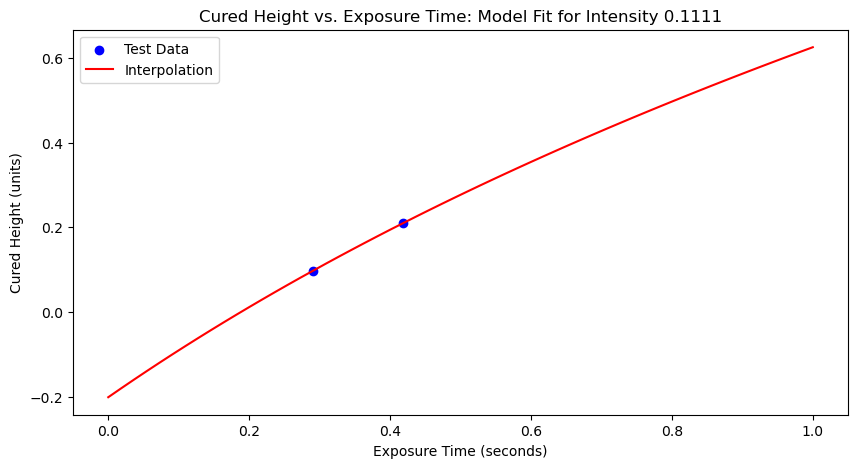

Intensity 0.1666666666666666: Optimized parameters: a=2.3193881511688232 b=0.5709855556488037, c=1.1095911264419556, d=-0.00737204123288393


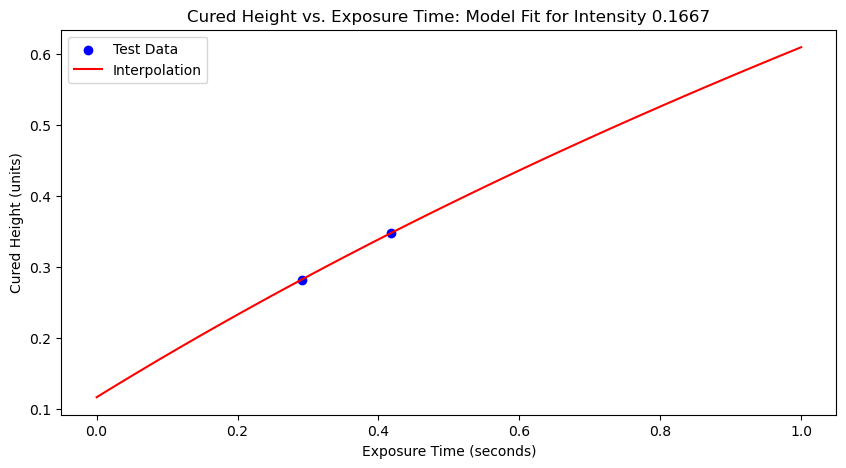

Intensity 0.2222222222222222: Optimized parameters: a=12.287359237670898 b=2.820990800857544, c=-0.18340449035167694, d=0.8377395272254944


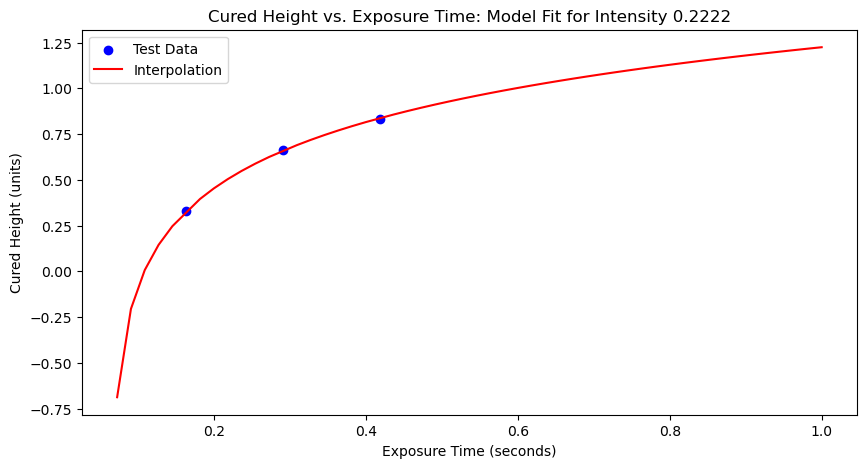

Intensity 0.2777777777777777: Optimized parameters: a=27.89332389831543 b=2.8920743465423584, c=-0.34531787037849426, d=0.9721148014068604


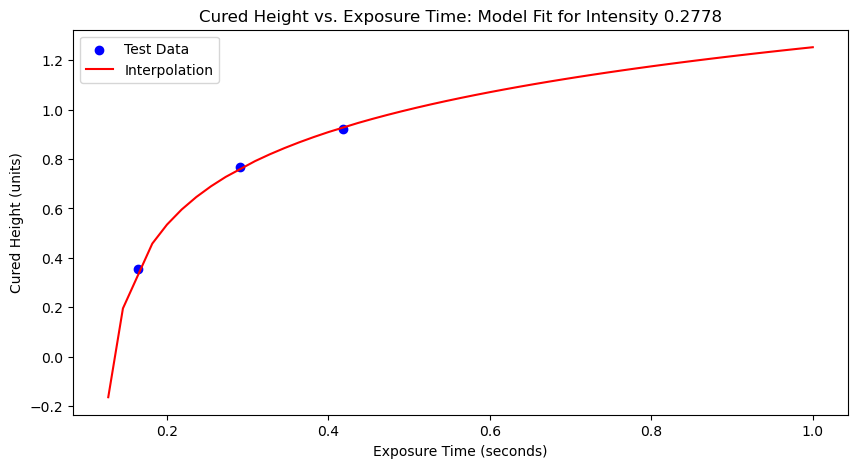

Intensity 0.3333333333333333: Optimized parameters: a=1.2524669170379639 b=0.6420246958732605, c=1.0279479026794434, d=0.029689598828554153


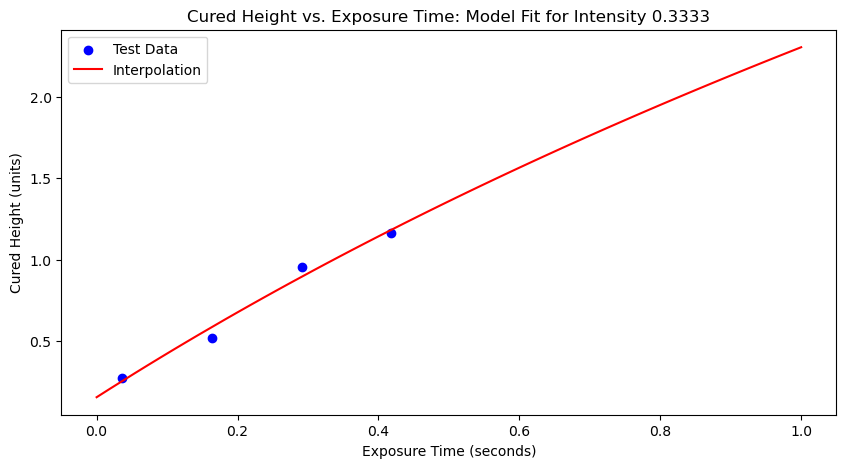

Intensity 0.3888888888888888: Optimized parameters: a=2.3832602500915527 b=2.9101948738098145, c=0.5215215086936951, d=0.7031884789466858


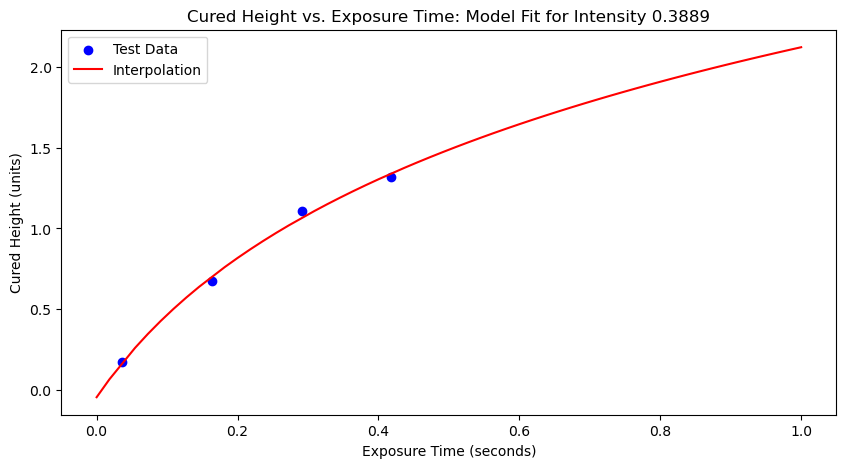

Intensity 0.4444444444444443: Optimized parameters: a=2.2531850337982178 b=2.688880205154419, c=0.5719271302223206, d=0.5977617502212524


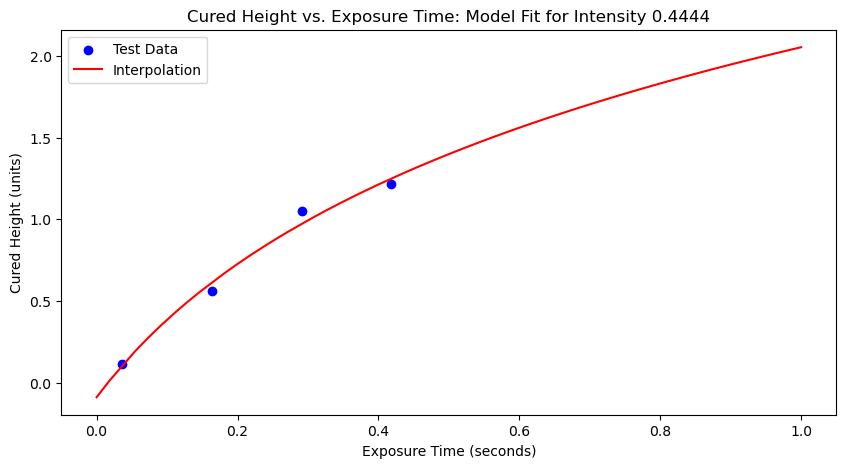

Intensity 0.4999999999999999: Optimized parameters: a=2.636106014251709 b=3.2007710933685303, c=0.3718928396701813, d=0.9113313555717468


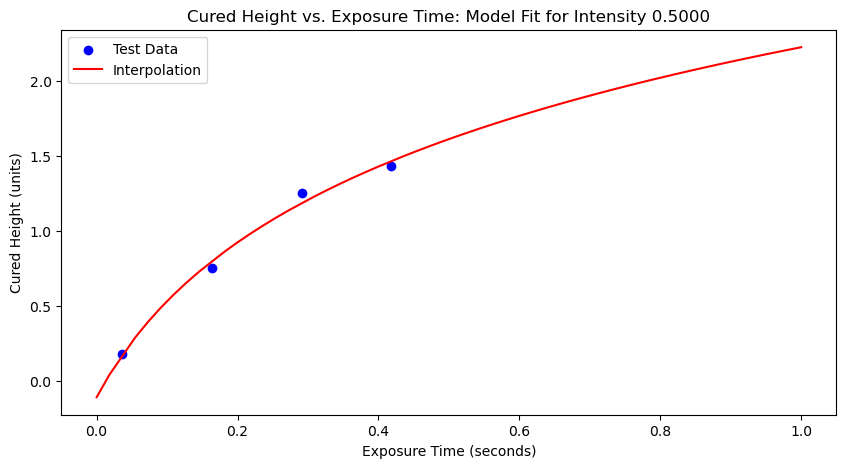

Intensity 0.5555555555555556: Optimized parameters: a=2.0018062591552734 b=2.748119831085205, c=0.673629105091095, d=0.5684868097305298


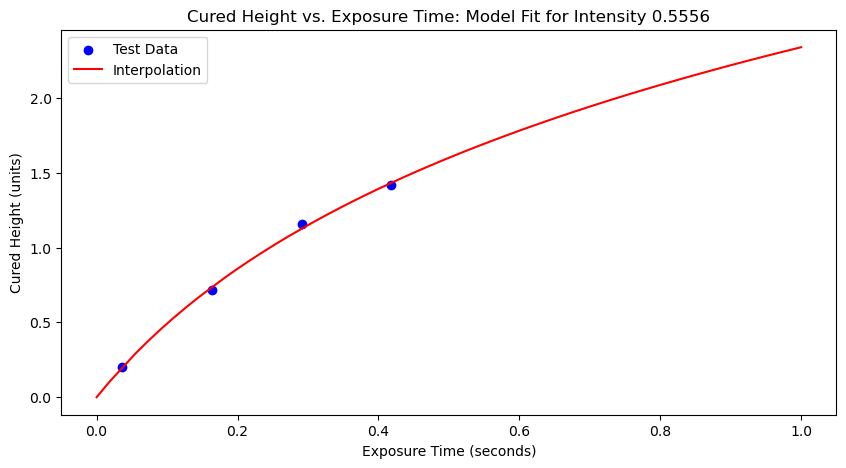

Intensity 0.6111111111111109: Optimized parameters: a=2.6224348545074463 b=3.4801855087280273, c=0.39537522196769714, d=1.0344643592834473


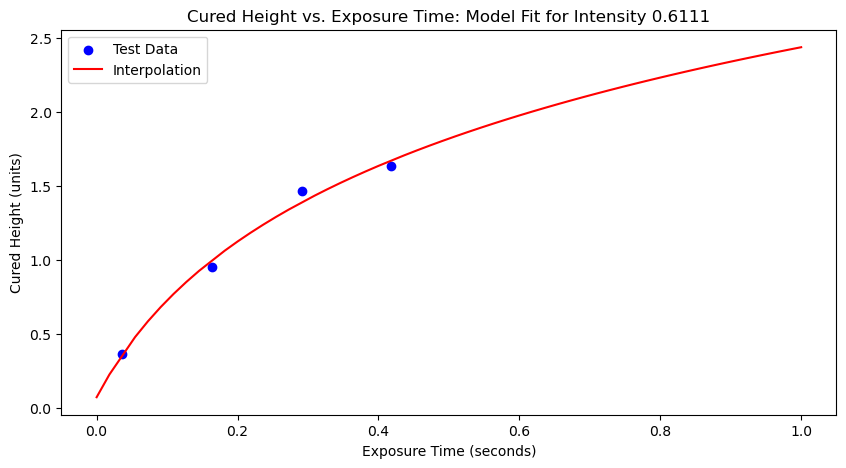

Intensity 0.6666666666666665: Optimized parameters: a=2.783118486404419 b=3.6653833389282227, c=0.3506159782409668, d=1.1650044918060303


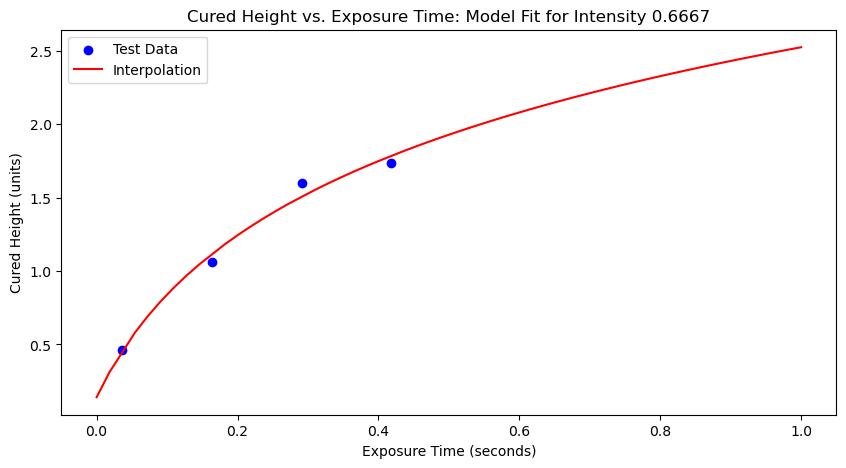

Intensity 0.7222222222222221: Optimized parameters: a=2.203392267227173 b=3.3662211894989014, c=0.6019333004951477, d=0.8830686211585999


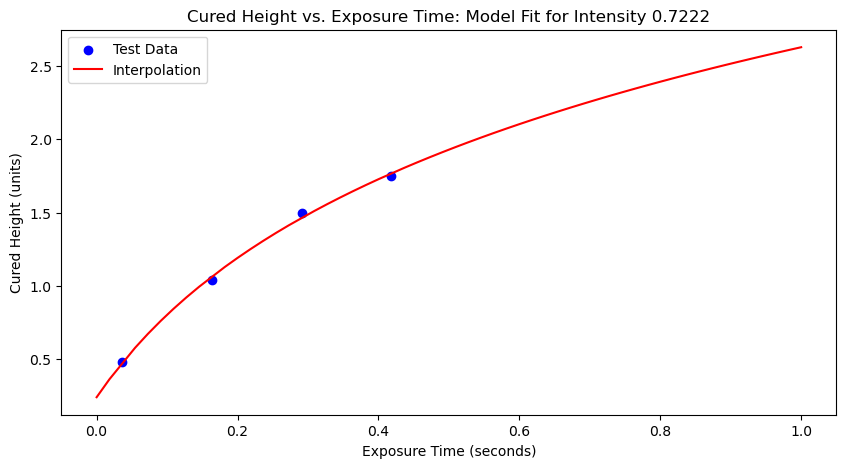

Intensity 0.7777777777777777: Optimized parameters: a=2.485610008239746 b=3.609212875366211, c=0.443094938993454, d=1.0845398902893066


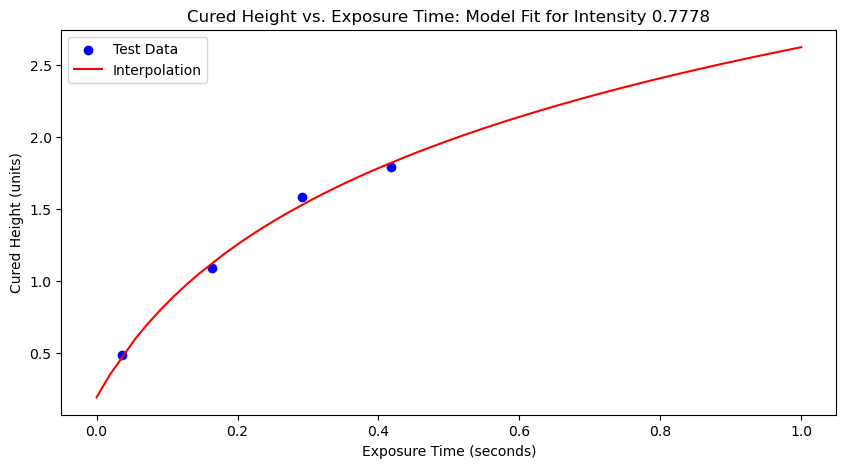

Intensity 0.8333333333333333: Optimized parameters: a=2.0319292545318604 b=3.5823585987091064, c=0.6033568382263184, d=0.9868434071540833


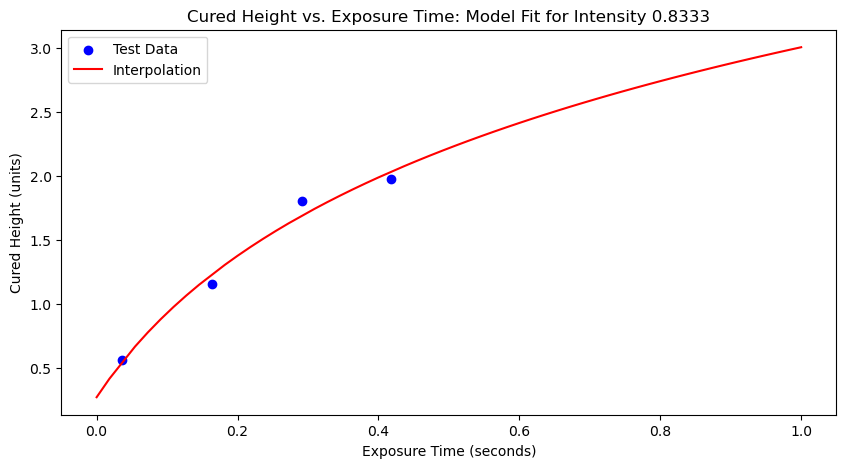

Intensity 0.8888888888888886: Optimized parameters: a=2.611563205718994 b=3.661050319671631, c=0.3780771493911743, d=1.1467304229736328


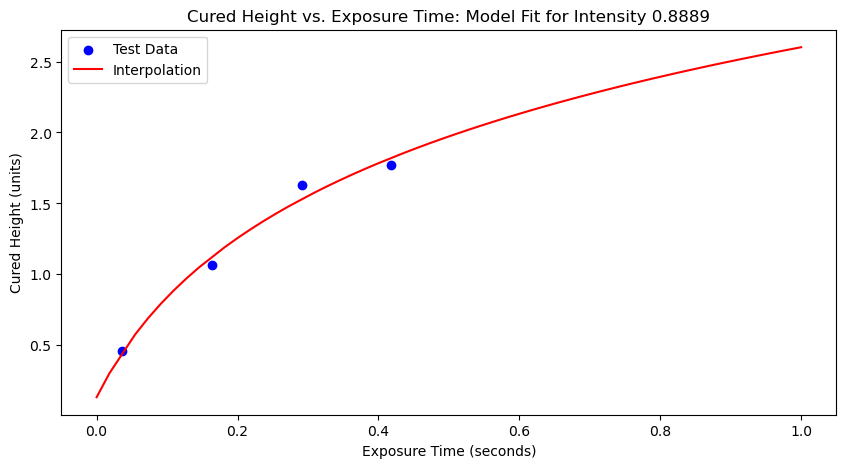

Intensity 0.9444444444444442: Optimized parameters: a=2.4671974182128906 b=3.703972339630127, c=0.3456375002861023, d=1.1851099729537964


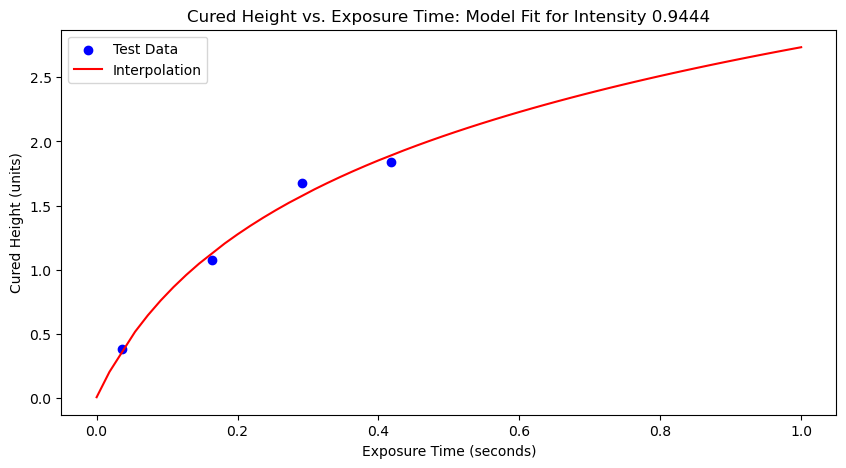

Intensity 0.9999999999999998: Optimized parameters: a=2.1589291095733643 b=3.6277313232421875, c=0.538165807723999, d=1.0436254739761353


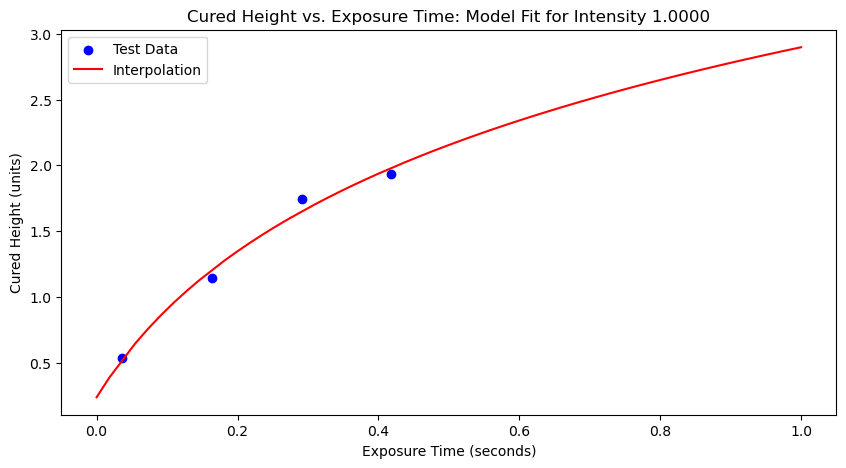

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from make_dataset import apply_scaler
from torch.utils.data import DataLoader

df_origin = pd.read_csv('./data_minmax_scale.csv')
unique_exposure_times = df_origin['exposure_time'].unique()
x_data_to_pred = np.sort(unique_exposure_times)
df_experiment_scaled = pd.read_csv('./data_experiment.csv')

grouped = df_experiment_scaled.groupby('intensity')
def model(x, params):
    a, b, c, d = params[0], params[1], params[2], params[3]
    # log_a(bx + c) + d, log_a(bx + c)는 log(bx + c) / log(a)
    return torch.log(b * x + c) / torch.log(a) + d
for name, group in grouped:
    x = torch.tensor(group['exposure_time'].values, dtype=torch.float32)
    y = torch.tensor(group['cured_height'].values, dtype=torch.float32)

    x_data = group['exposure_time'].to_numpy()
    y_data = group['cured_height'].to_numpy()
    mask = np.isin(x_data_to_pred, x_data)
    close_mask = np.array([np.any(np.isclose(x, x_data)) for x in x_data_to_pred])
    combined_mask = mask | close_mask
    x_data_to_pred_filtered = x_data_to_pred[~combined_mask]
    
    params = torch.tensor([2.0, 1.0, 1.0, 0.0], requires_grad=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam([params], lr=0.001)
    min_loss =float('inf')
    attempt = 0
    while attempt < 10:
        optimizer.zero_grad()
        output = model(x, params)
        loss = criterion(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if loss.item() < min_loss:
            min_loss = loss.item()
            attempt = 0
        else:
            attempt += 1
    
    print(f"Intensity {name}: Optimized parameters: a={params[0]} b={params[1]}, c={params[2]}, d={params[3]}")
    
    x_data_to_pred_filtered_tensor = torch.tensor(x_data_to_pred_filtered)
    y_pred_filtered = model(x_data_to_pred_filtered_tensor, params).detach().numpy()
    intensity = name
    plt.figure(figsize=(10, 5))
    plt.scatter(x_data, y_data, color='blue', label='Test Data')
    plt.plot(x_data_to_pred_filtered, y_pred_filtered, color='red', label='Interpolation')
    plt.title('Cured Height vs. Exposure Time: Model Fit for Intensity {:.4f}'.format(intensity))
    plt.xlabel('Exposure Time (seconds)')
    plt.ylabel('Cured Height (units)')
    plt.legend()
    plt.show()

Intensity 0.9999999999999998: Optimized parameters: a=12.287359237670898 b=2.820990800857544, c=-0.18340449035167694, d=0.8377395272254944


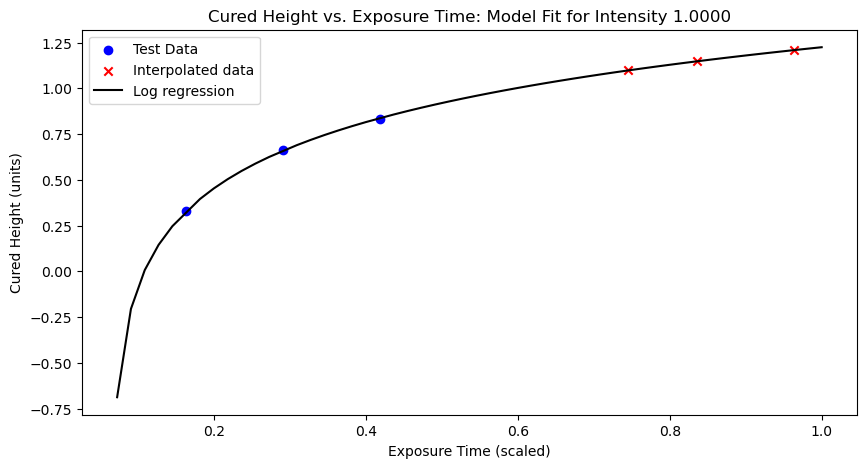

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from make_dataset import apply_scaler
from torch.utils.data import DataLoader

df_origin = pd.read_csv('./data_minmax_scale.csv')
unique_exposure_times = df_origin['exposure_time'].unique()
x_data_to_pred = np.sort(unique_exposure_times)

def model(x, params):
    a, b, c, d = params[0], params[1], params[2], params[3]
    # log_a(bx + c) + d, log_a(bx + c)는 log(bx + c) / log(a)
    return torch.log(b * x + c) / torch.log(a) + d

x = torch.tensor([0.16363636, 0.29090909, 0.41818182], dtype=torch.float32)
y = torch.tensor([0.32692308, 0.66083916, 0.83391608], dtype=torch.float32)

x_data = [0.16363636, 0.29090909, 0.41818182]
y_data = [0.32692308, 0.66083916, 0.83391608]
mask = np.isin(x_data_to_pred, x_data)
close_mask = np.array([np.any(np.isclose(x, x_data)) for x in x_data_to_pred])
combined_mask = mask | close_mask
x_data_to_pred_filtered = x_data_to_pred[~combined_mask]

params = torch.tensor([12.287359237670898, 2.820990800857544, -0.18340449035167694, 0.8377395272254944], requires_grad=True)


print(f"Intensity {name}: Optimized parameters: a={params[0]} b={params[1]}, c={params[2]}, d={params[3]}")

x_data_to_pred_filtered_tensor = torch.tensor(x_data_to_pred_filtered)
y_pred_filtered = model(x_data_to_pred_filtered_tensor, params).detach().numpy()
intensity = name
x_interpol = [0.963636363636363, 0.836363636363636, 0.745454545454545]
y_interpol = [1.20854644728886, 1.14766670412817, 1.0976775530254361]
plt.figure(figsize=(10, 5))
plt.scatter(x_data, y_data, color='blue', label='Test Data')
plt.scatter(x_interpol, y_interpol, color='red', label='Interpolated data', marker='x')
plt.plot(x_data_to_pred_filtered, y_pred_filtered, color='black', label='Log regression')
plt.title('Cured Height vs. Exposure Time: Model Fit for Intensity {:.4f}'.format(intensity))
plt.xlabel('Exposure Time (scaled)')
plt.ylabel('Cured Height (units)')
plt.legend()
plt.show()